In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [3]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [4]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=.02, sigma=.01)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=0, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=.2)
    beta_H = pm.Normal("beta_H", mu=1, sigma=.2)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    # beta_H2 = pm.Normal("beta_H2", mu=3, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    # alpha_2 = pm.Normal("alpha_2", mu=30, sigma=5)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)
    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / (n_LF**(beta_L)) + 1 / (n_HF**(beta_H)))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [5]:
error_mean

0.15970307871492706

In [6]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 137 seconds.
There were 869 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 1MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     beta_H   (chain, draw) float64 192kB 1.26 1.242 1.224 ... 1.464 1.464 1.471
     beta_L   (chain, draw) float64 192kB 0.5055 0.4981 0.4822 ... 0.4824 0.4819
     eta      (chain, draw) float64 192kB 0.02525 0.01506 ... 0.01031 0.01024
     rho      (chain, draw) float64 192kB 57.66 91.63 54.14 ... 125.5 125.5 127.6
     sigma    (chain, draw) float64 192kB 0.1066 0.1091 0.1041 ... 0.1054 0.1055
 Attributes:
     created_at:                 2024-08-11T19:22:45.209546+00:00
     arviz_version:              0.18.0
     inference_library:          pymc
     inference_library_version:  5.16.1
     sampling_time:              137.3545060157776
     tuning_steps:               2000,
 'sample_stats': <xarray.Dataset> Size: 3MB
 Dimensions:                (chain: 4

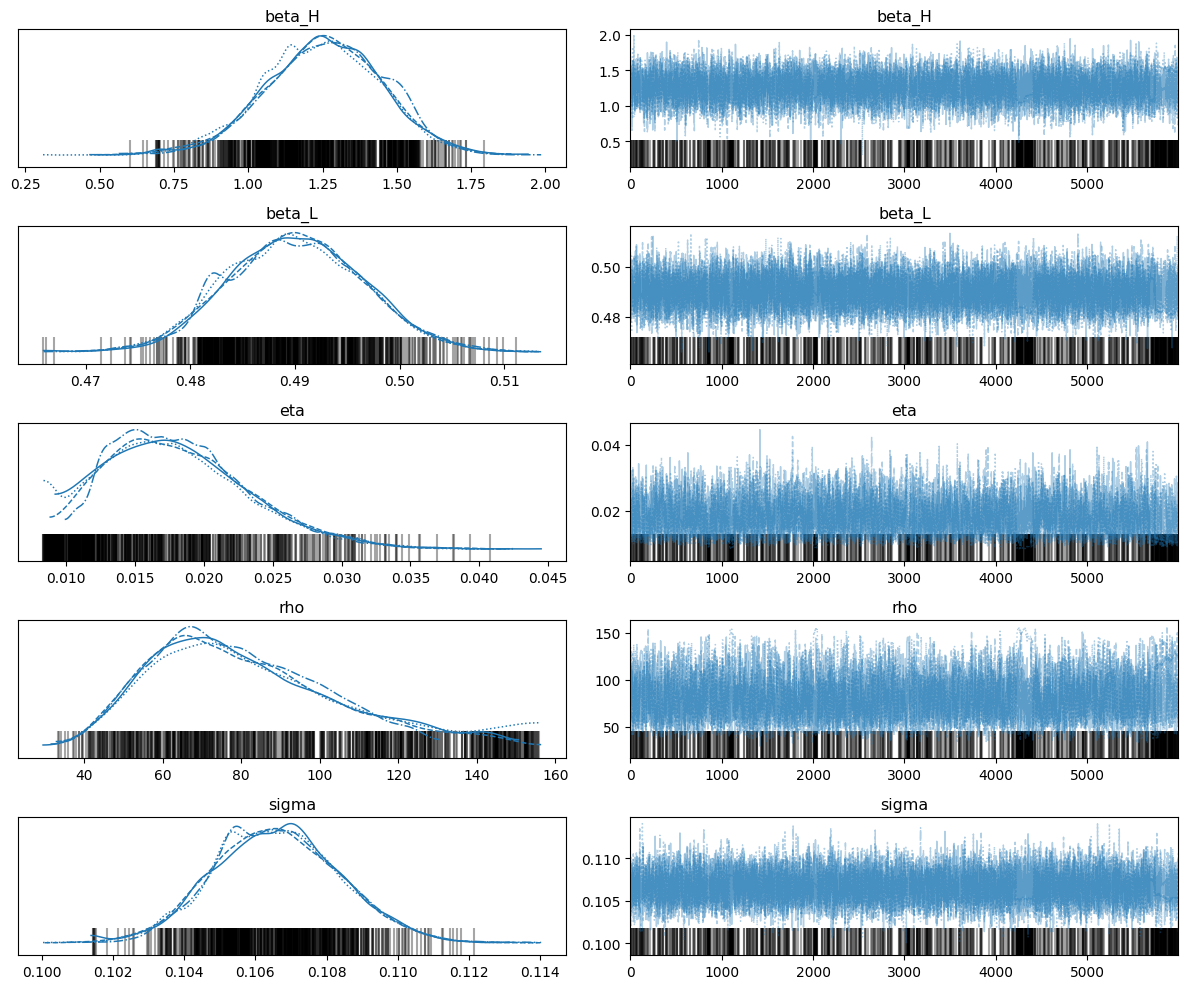

In [8]:
az.plot_trace(idata)
plt.tight_layout()

In [9]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[0.01280288 0.01749873 0.02326996]
[ 57.81088149  76.84381849 104.93402205]
[0.48345558 0.48996187 0.49660497]
[1.06014988 1.25873482 1.45320235]


In [10]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_H,1.255,0.197,0.896,1.633,0.003,0.002,5194.013,7731.607,1.001
beta_L,0.490,0.006,0.478,0.503,0.000,0.000,4155.126,12028.532,1.001
eta,0.018,0.005,0.009,0.027,0.000,0.000,1091.008,482.292,1.006
rho,80.865,23.783,41.431,126.117,0.792,0.645,1186.316,536.694,1.006
sigma,0.107,0.002,0.103,0.110,0.000,0.000,8261.514,8580.317,1.001


In [11]:
from scipy.stats import gaussian_kde

# Assuming `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Function to compute the mode using KDE
def get_mode_kde(data):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    mode = x_grid[np.argmax(kde(x_grid))]
    return mode

# Extracting modes for each parameter using KDE
kde_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_mode_kde(samples)
    kde_modes[var] = mode

print("KDE modes of each posterior:")
for var, mode in kde_modes.items():
    print(f"{var}: {mode}")


KDE modes of each posterior:
beta_H: 1.2559443138936368
beta_L: 0.4892037815802024
eta: 0.015456177274366696
rho: 67.47034833383987
sigma: 0.10685587017308326


In [12]:
posterior_eta.values.flatten()

array([0.02524588, 0.01506041, 0.02359768, ..., 0.01031028, 0.01031028,
       0.01023592])

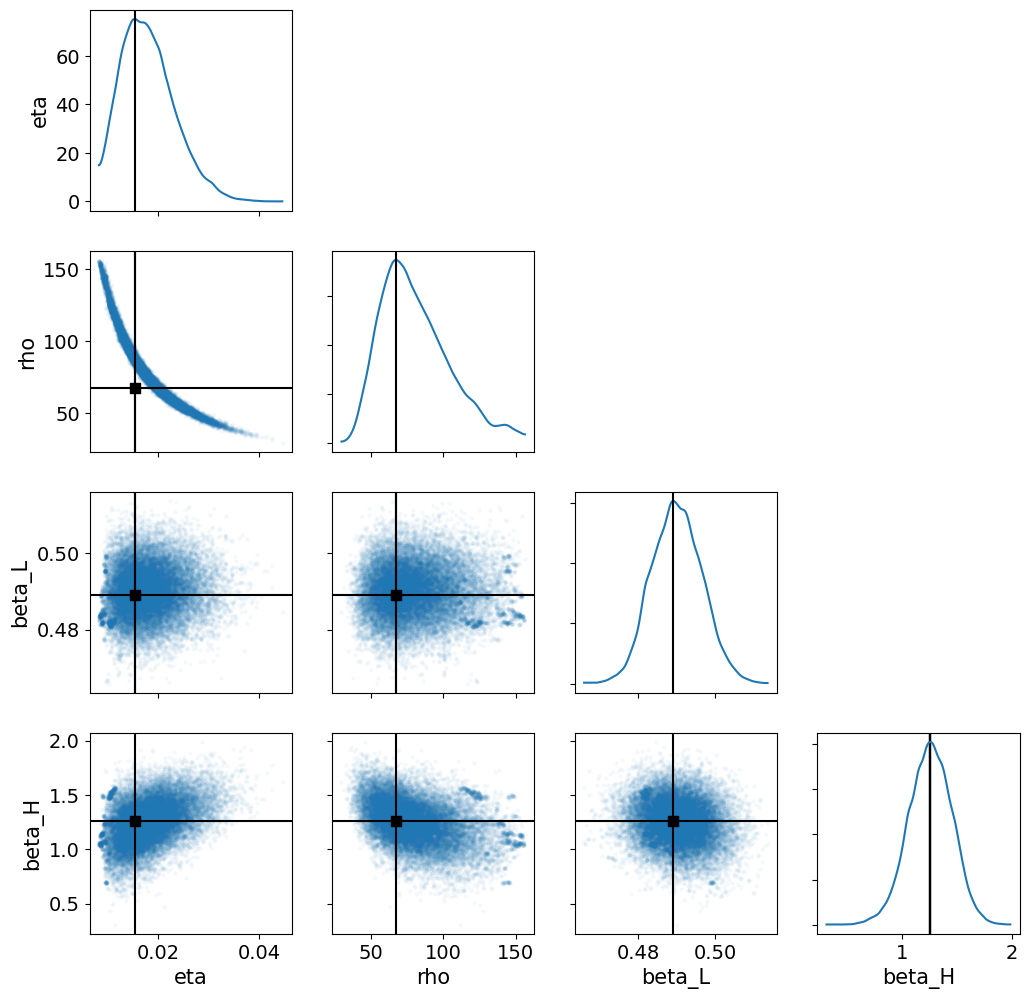

In [13]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="mode",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [18]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import arviz as az  # Assuming `idata` is an ArviZ InferenceData object

# Assume `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Define a function to evaluate the joint density using KDE
def joint_kde_density(point, samples):
    kde = gaussian_kde(samples.T)  # Transpose for proper shape
    return -kde(point)  # Negative because we are minimizing

# Extract the samples of the parameters of interest (e.g., rho and eta)
rho_samples = posterior_samples['rho'].values.flatten()
eta_samples = posterior_samples['eta'].values.flatten()

# Combine samples into a 2D array for joint distribution
joint_samples = np.vstack([rho_samples, eta_samples]).T

# Initial guess for the optimizer (mean of samples can be a good starting point)
initial_guess = np.mean(joint_samples, axis=0)

# Perform the optimization to find the mode
result = minimize(joint_kde_density, initial_guess, args=(joint_samples,), method='L-BFGS-B')

# The result contains the mode of the joint distribution
global_mode = result.x

print(f"Global mode of the joint distribution (rho, eta): {global_mode}")

Global mode of the joint distribution (rho, eta): [8.08647377e+01 1.67104098e-02]


In [21]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import arviz as az  # Assume idata is an ArviZ InferenceData object

# Assume `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Define a function to evaluate the joint density using KDE
def joint_kde_density(point, samples):
    kde = gaussian_kde(samples.T)  # Transpose for proper shape
    return -kde(point)  # Negative because we are minimizing

# Extract the samples of all four parameters of interest
param_names = ['rho', 'eta', 'beta_L', 'beta_H']  # Replace with actual parameter names
sample_arrays = [posterior_samples[param].values.flatten() for param in param_names]

# Combine samples into a 2D array for joint distribution
joint_samples = np.vstack(sample_arrays).T

# Initial guess for the optimizer (mean of samples can be a good starting point)
initial_guess = np.mean(joint_samples, axis=0)

# Perform the optimization to find the mode
result = minimize(joint_kde_density, initial_guess, args=(joint_samples,), method='L-BFGS-B')

# The result contains the mode of the joint distribution
global_mode = result.x

# Print the global mode of the joint distribution
print(f"Global mode of the joint distribution ({', '.join(param_names)}): {global_mode}")

Global mode of the joint distribution (rho, eta, beta_L, beta_H): [8.08640709e+01 1.67389741e-02 4.89996378e-01 1.21320976e+00]


In [14]:
# naive lg_Phi
def error_function(n_LF, n_HF):
    eta = 0.7947996701660118
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 5.608704513443982
    beta_L = 1.2974943261842817
    beta_H = 1.5156154430804256

    sigma_lg_Phi = 0.30695835929339044	   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / (n_LF**(beta_L)) + 1 / (n_HF**(beta_H)))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [15]:
# loss  mean

lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - np.log(rel_error))**2)

In [16]:
loss

0.5003782616549606